In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/train.csv')

In [4]:
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

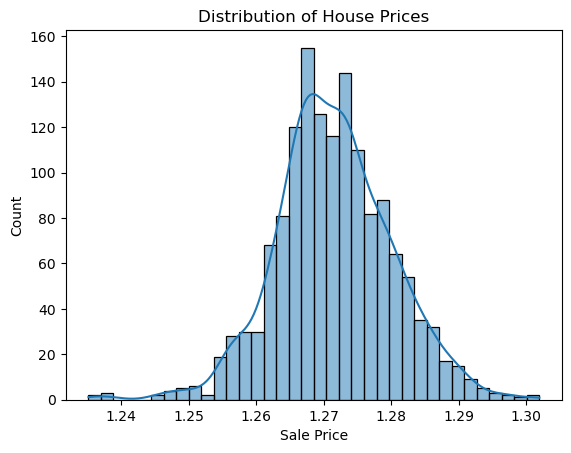

In [126]:
# Visualize target variable distribution
import os
os.makedirs('notebooks', exist_ok=True)
sns.histplot(df['SalePrice'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.savefig('notebooks/type_distribution.png', dpi=300, bbox_inches='tight')


plt.show()

In [12]:
# Correlation matrix with SalePrice
corr = df.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(10)

print(top_corr)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


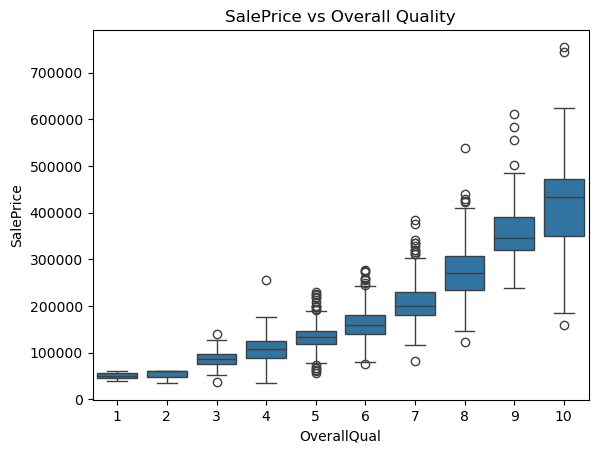

In [14]:
# Example: OverallQual vs SalePrice
sns.boxplot(x='OverallQual', y='SalePrice', data=df)
plt.title('SalePrice vs Overall Quality')
plt.show()


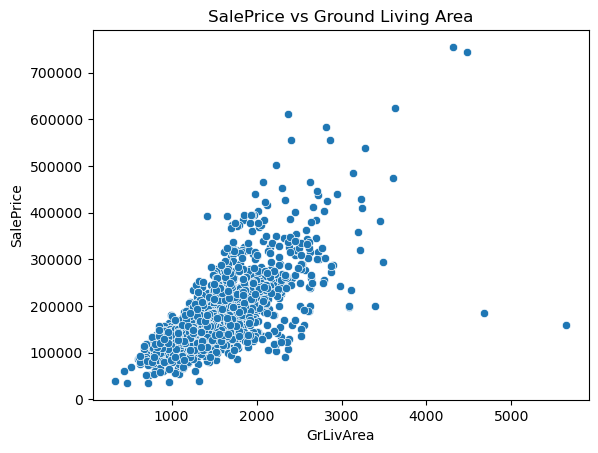

In [16]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('SalePrice vs Ground Living Area')
plt.show()

In [64]:
# Find features with missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

GarageYrBlt    81
MasVnrArea      8
dtype: int64


In [66]:
# Fill NA for numerical columns with median
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

if 'GarageType' in df.columns:
    df['GarageType'] = df['GarageType'].fillna('None')

In [68]:
# Combine related features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Log-transform the target to reduce skew
import numpy as np
df['SalePrice'] = np.log1p(df['SalePrice'])

In [80]:
df = pd.get_dummies(df)

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [84]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
missing = X.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

GarageYrBlt    81
MasVnrArea      8
dtype: int64

In [90]:
# For numerical columns
X = X.fillna(X.median(numeric_only=True))

# For categorical columns
X = X.fillna("None")

In [102]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Fit on training data
X_train_encoded = encoder.fit_transform(X_train[cat_cols])
X_test_encoded = encoder.transform(X_test[cat_cols])

# Convert encoded arrays to DataFrames
encoded_train_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(cat_cols))
encoded_test_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Reset index to align
encoded_train_df.index = X_train.index
encoded_test_df.index = X_test.index

# Drop original categorical columns and concat encoded
X_train = pd.concat([X_train.drop(columns=cat_cols), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_cols), encoded_test_df], axis=1)


In [106]:
from sklearn.impute import SimpleImputer

# Auto-detect categorical columns if not already defined
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Check that categorical columns are present in X_train
valid_cat_cols = [col for col in cat_cols if col in X_train.columns]

if valid_cat_cols:
    # Impute categorical columns with a constant value "Missing"
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
    
    # Fit and transform on train data
    X_train[valid_cat_cols] = cat_imputer.fit_transform(X_train[valid_cat_cols])
    
    # Only transform on test data
    X_test[valid_cat_cols] = cat_imputer.transform(X_test[valid_cat_cols])
else:
    print("⚠️ No valid categorical columns found for imputation.")


⚠️ No valid categorical columns found for imputation.


In [108]:
# Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [110]:
y_pred = model.predict(X_test)

In [112]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.0028932871842669416


In [116]:
# Calculate R² score
from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

R² Score: 0.9036667515386958


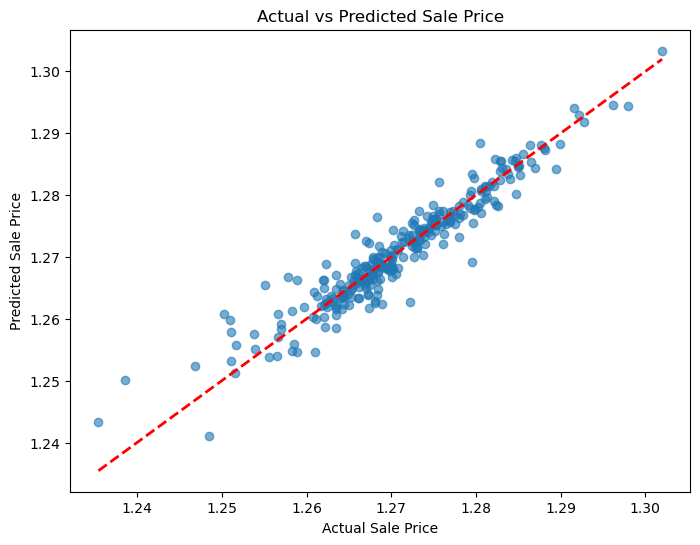

In [118]:
# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')

# Save figure
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')

plt.show()